In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from itertools import product
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import joblib  # 모델 저장을 위한 라이브러리

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
def calculate_metrics(y_true, y_pred, training_time):
	"""평가 지표 계산 함수"""
	return {
		'MAE': mean_absolute_error(y_true, y_pred),
		'MSE': mean_squared_error(y_true, y_pred),
		'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
		'R2': r2_score(y_true, y_pred),
		'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
		'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
		'Training_Time': training_time
	}

### 광어

In [42]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
		'n_estimators': 90,
		'max_depth': 7,
		'learning_rate':  0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9 ,
		'random_state': 1030,
		'n_jobs': -1
	}

	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")



	# 상승/하락 적중률 계산
	actual_trend = np.sign(y.diff(axis=1).fillna(0))
	predicted_trend = np.sign(y_pred[:, 1:] - y_pred[:, :-1])
	trend_accuracy = (actual_trend.iloc[:, 1:].values == predicted_trend).mean(axis=0) * 100

	avg_accuracy = np.mean(trend_accuracy)
	min_accuracy, max_accuracy = np.min(trend_accuracy), np.max(trend_accuracy)
	min_day, max_day = np.argmin(trend_accuracy) + 2, np.argmax(trend_accuracy) + 2

	print(f"\n평균 상승/하락 적중률: {avg_accuracy:.2f}%")
	print(f"최저 적중률: {min_accuracy:.2f}% (Day {min_day})")
	print(f"최고 적중률: {max_accuracy:.2f}% (Day {max_day})")

	# 상승/하락 적중률 그래프
	plt.figure(figsize=(10, 5))
	plt.plot(range(2, steps + 1), trend_accuracy, marker='o', linestyle='-', label='적중률')
	plt.axhline(avg_accuracy, color='r', linestyle='--', label=f'평균 적중률: {avg_accuracy:.2f}%')
	plt.scatter(min_day, min_accuracy, color='blue', label=f'최저점: Day {min_day} ({min_accuracy:.2f}%)')
	plt.scatter(max_day, max_accuracy, color='green', label=f'최고점: Day {max_day} ({max_accuracy:.2f}%)')
	plt.xlabel('예측 일 수')
	plt.ylabel('적중률 (%)')
	plt.title('가격 상승/하락 적중률')
	plt.legend()
	plt.grid()
	plt.show()






	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()



	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26233, number of used features: 32
[LightGBM] [Info] Start training from score 35911.720733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26233, number of used features: 32
[LightGBM] [Info] Start training from score 35912.028742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26233, number of used features: 32
[LightGBM] [Info] S

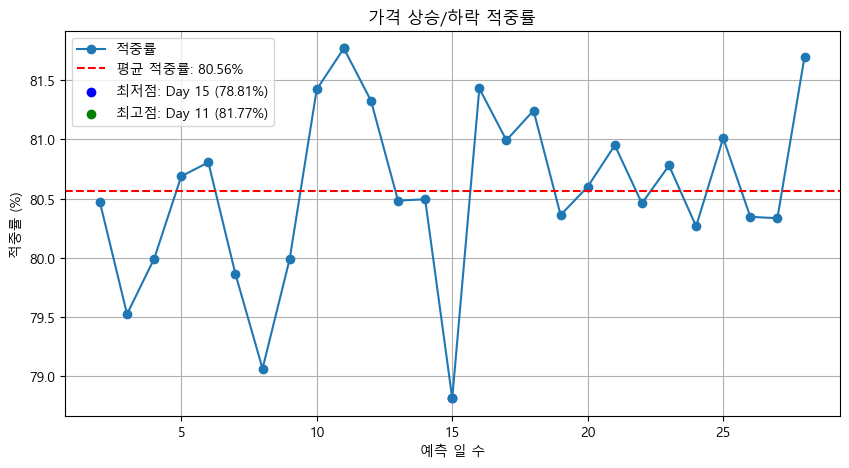


Feature Importances:
             Feature  Importance
10    avgPrice_lag_1   65.928571
21       광어_Gold_314   65.178571
25      광어_USD/KRW_1   55.607143
27          광어_WTI_1   40.142857
22      광어_KOSPI_136   33.178571
6        m_소래포구종합어시장   27.071429
4         m_마포농수산물시장   26.571429
3            m_노량진시장   25.642857
7         m_수원농수산물시장   25.285714
0             m_가락시장   25.071429
5      m_부산민락어민활어직판장   24.178571
24     광어_Silver_238   24.071429
1         m_강서농수산물시장   23.928571
2         m_구리농수산물시장   23.785714
8       m_안양평촌농수산물시장   23.642857
9      m_인천종합연안부두어시장   20.178571
29    광어_수온_22107_79   19.785714
23        광어_MOVE_18   18.428571
28    광어_기온_22105_97   18.214286
26        광어_VIX_399   17.142857
12        광어_20대_250    9.607143
14        광어_30대_317    5.071429
16        광어_40대_330    3.321429
13          광어_30대_1    1.892857
11          광어_20대_1    1.678571
31  광어_파주기_22190_103    1.678571
18        광어_50대_395    1.642857
15          광어_40대_1    1.178571
20      광어_60대이상_339 

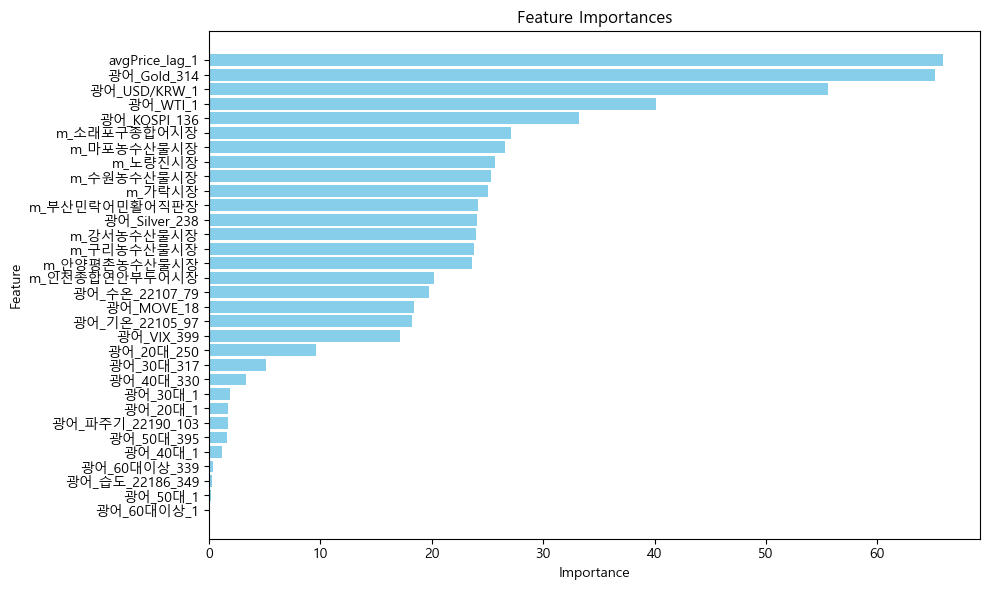

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=7,
                                             min_child_samples=6,
                                             n_estimators=90, n_jobs=-1,
                                             num_leaves=8, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_광어.joblib'로 저장되었습니다.


In [44]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv')
exclude_features = []
model_다중_광어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_광어)

# 학습된 모델 저장
joblib.dump(model_다중_광어, 'lgbm_다중_광어.joblib')  

print("\n학습된 모델이 'lgbm_다중_광어.joblib'로 저장되었습니다.")

### 농어

In [6]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 100,
		'max_depth': 6,
		'learning_rate': 0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

# 상승/하락 예측 정확도 계산
	direction_accuracy = calculate_direction_accuracy_multi(y, y_pred)

	# 결과 출력
	print("\n** 상승/하락 예측 정확도 (각 Step 별) **")
	for step, acc in direction_accuracy.items():
		print(f"{step}일 후: {acc:.2f}%")


	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5560
[LightGBM] [Info] Number of data points in the train set: 24995, number of used features: 30
[LightGBM] [Info] Start training from score 36137.697540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5560
[LightGBM] [Info] Number of data points in the train set: 24995, number of used features: 30
[LightGBM] [Info] Start training from score 36138.217644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5560
[LightGBM] [Info] Number of data points in the train set: 24995, number of used features: 30
[LightGBM] [Info] S

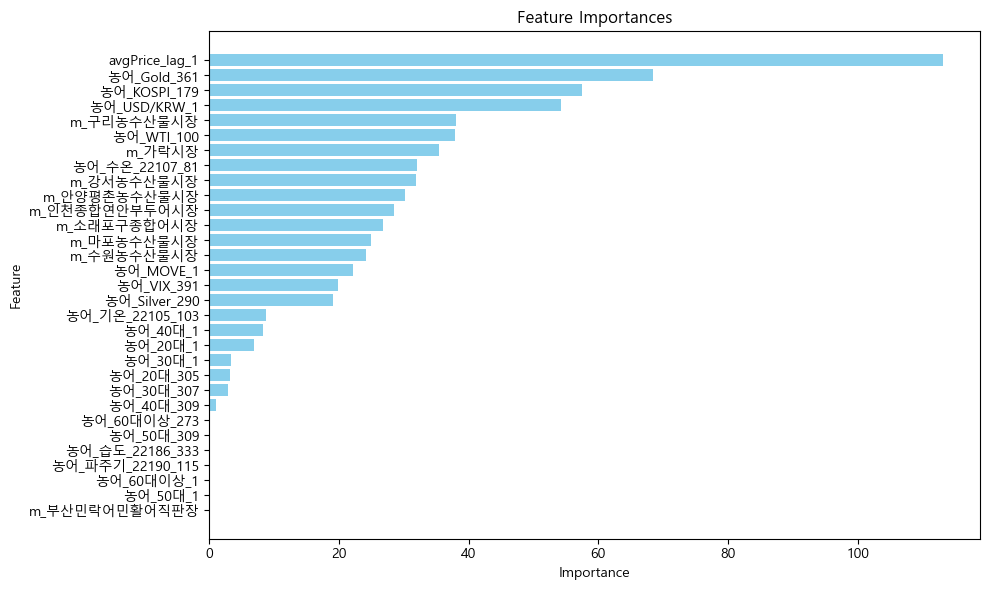

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=6,
                                             min_child_samples=6, n_jobs=-1,
                                             num_leaves=8, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_농어.joblib'로 저장되었습니다.


In [7]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/농어_price_features_notnull.csv')
exclude_features = ['m_노량진시장']
model_다중_농어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_농어)

# 학습된 모델 저장
joblib.dump(model_다중_농어, 'lgbm_다중_농어.joblib')  

print("\n학습된 모델이 'lgbm_다중_농어.joblib'로 저장되었습니다.")

### 대게

In [9]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 90,
		'max_depth': 7,
		'learning_rate': 0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/대게_price_features_notnull.csv')
exclude_features = ['m_노량진시장']
model_다중_대게 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_대게)

# 학습된 모델 저장
joblib.dump(model_다중_대게, 'lgbm_다중_대게.joblib')  

print("\n학습된 모델이 'lgbm_다중_대게.joblib'로 저장되었습니다.")

### 방어

In [11]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 45,
		'max_depth': 2,
		'learning_rate': 0.11,
		'num_leaves': 4,
		'min_child_samples': 7,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/방어_price_features_notnull.csv')
exclude_features = [
        '방어_60대이상_1',
        '방어_50대_256',
  '방어_파주기_22105_191'    
	
]
model_다중_방어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_방어)

# 학습된 모델 저장
joblib.dump(model_다중_방어, 'lgbm_다중_방어.joblib')  

print("\n학습된 모델이 'lgbm_다중_방어.joblib'로 저장되었습니다.")

### 연어 노르웨이 제외 

In [ ]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 60,
		'max_depth': 7,
		'learning_rate': 0.09,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/연어_price_features_notnull_노르웨이제외.csv')
exclude_features = [
        '연어_40대_21',
     '연어_60대이상_397',
        '연어_50대_15',
   '연어_파주기_22190_9',

       '연어_60대이상_1',
         '연어_50대_1',
         '연어_40대_1',
         '연어_30대_1',
        '연어_30대_15'


]
model_다중_연어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_연어)

# 학습된 모델 저장
joblib.dump(model_다중_연어, 'lgbm_다중_연어.joblib')  

print("\n학습된 모델이 'lgbm_다중_연어.joblib'로 저장되었습니다.")

### 우럭

In [18]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
        'n_estimators': 105 ,
        'max_depth': 3,
        'learning_rate': 0.1,
        'num_leaves': 4,
        'min_child_samples': 8,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'random_state': 1030,
        'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/우럭_price_features_notnull.csv')
exclude_features = []
model_다중_우럭 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_우럭)

# 학습된 모델 저장
joblib.dump(model_다중_우럭, 'lgbm_다중_우럭.joblib')  

print("\n학습된 모델이 'lgbm_다중_우럭.joblib'로 저장되었습니다.")

### 참돔


In [22]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 90,
		'max_depth': 7,
		'learning_rate': 0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/참돔_price_features_notnull.csv')
exclude_features = []
model_다중_참돔 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_참돔)

# 학습된 모델 저장
joblib.dump(model_다중_참돔, 'lgbm_다중_참돔.joblib')  

print("\n학습된 모델이 'lgbm_다중_참돔.joblib'로 저장되었습니다.")

### 가격 예측 

In [ ]:
# 저장된 모델 로드
loaded_model = joblib.load('lgbm_다중_광어.joblib')
print("모델이 성공적으로 로드되었습니다.")